# Business Understanding

It is my task to help Tensa with computer vision for their A.I. tennis ball machine.

# Data Understanding

I created all the data used in this project. I used roughly 3,000 images that consisted of a balanced class of forehand and backhand tennis shots. 
The limitations of the dataset was that it was a fairly small set of data. The images used only consisted of myself hitting forehand and backhand tennis shots. The data used for this project was useful to build a convolutional neural network for image classification because their was a minimal amount of variance in the data used. The neural net was able to learn specific patterns about forehands and backhands with minimal "noise" in the data because of the consistency of the data used.


# Data Preperation

   I started by filming myself in a few different locations hitting approximately 200 forehands and 200 backhands. I then used an open source editing program called "Shotcut" to edit all of my swings from the start of my swing up until the point of contact with the tennis ball. I then converted these edited video shots into an mp4 format so that they could be extracted into frames.
    I extracted the frames into folders and labeled the frames as either belonging to one of two classes "1" for forehand and "0" for backhand. I constructed an iterator into my pipeline to be able to call on specific "batches" of data. I then scaled my data in the pipeline to make sure that all the images used were the same size.
    I then set up a train, test, split which was 80% for training, 10% for validation, and 10% for testing. I then set up a way to save and load my data after it has been trained into my pipeline so that more data could be input in the future.

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import os
import PIL
import tensorflow as tf
import pickle
import hashlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

The cell below enables you to select videos within a specified folder. The function enables you to extract frames from the video file and puts them into a specified folder within the directory. It iterates thru all video files ending with' mp4' and 'avi' and saves the the extracted frames into a specified folder.

In [2]:
# Directory containing the video files
video_directory = '/home/adam/Desktop/video_test'

# Output directory for extracted frames
output_directory = '/home/adam/Desktop/frame_test'

# Function to extract frames from a video file
def extract_frames(video_file, output_dir):
    # Open the video file
    vid = cv2.VideoCapture(video_file)
    if not vid.isOpened():
        print(f"Error: Couldn't open video file '{video_file}'")
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize frame counter
    current_frame = 0

    # Read frames and save them as images
    while True:
        success, frame = vid.read()

        if not success:
            print(f"End of video reached or couldn't read frame from '{video_file}'")
            break

        if frame.shape[0] > 0 and frame.shape[1] > 0:
            # Save the frame as an image
            output_path = os.path.join(output_dir, f'{os.path.splitext(os.path.basename(video_file))[0]}_{current_frame}.jpg')
            cv2.imwrite(output_path, frame)
            current_frame += 1
        else:
            print(f"Error: Invalid frame size in '{video_file}'")

    vid.release()

# Iterate over video files in the directory
for video_file in os.listdir(video_directory):
    if video_file.endswith('.mp4') or video_file.endswith('.avi'):
        video_path = os.path.join(video_directory, video_file)
        extract_frames(video_path, output_directory)

In [3]:
# Defining a data directory
data_dir = 'data'

The cell below sets up a variable to recognize different images types.

In [4]:
# Defining image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

The cell below shows that my data directory contains my 2 classes.

In [5]:
# Checking the contents of my data directory
os.listdir(data_dir)

['forehands', 'backhands']

The cell below sets up a for loop that goes thru the folders and all our images in the data directory and removes any images that does not have the appropriate image extensions. Note the skipping output is just skipping directories but there are no issues with the actual files in the directories.

In [6]:
# Iterate through directories containing images
for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_dir):
        continue  # Skip if not a directory
    for image in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image)
        if not os.path.isfile(image_path):
            print('Skipping non-file:', image_path)
            continue  # Skip if not a file
        try:
            tip = imghdr.what(image_path)  # Get image type directly
            if tip is None or tip not in image_exts:
                print('Image not in ext list or invalid format: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, str(e)))
            # Log the error or handle it appropriately

Skipping non-file: data/forehands/vids
Skipping non-file: data/forehands/frames
Skipping non-file: data/backhands/vids
Skipping non-file: data/backhands/frames


Here we start to preprocess the data, we are starting with approx. 3,000 images belonging to two classes that are fairly balanced. This sets up the data pipleline and enables access to "batches" of data using the iterator.

In [7]:
# loading in tensorflow and keras on our data 
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 6325 files belonging to 2 classes.


In [8]:
# allow acces to generator from the data pipeline
data_iterator = data.as_numpy_iterator()

In [9]:
# allow access to pull a batch (32 images) of data
batch = data_iterator.next()

batch size of 32, image size of 256x256, 3 (channels of color)

In [10]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [11]:
# representing the labels in the batch
batch[1]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1], dtype=int32)

Below I am plotting some images from a batch to see which classes my images belong to and we can see Forehands = 1 and Backhands = 0.

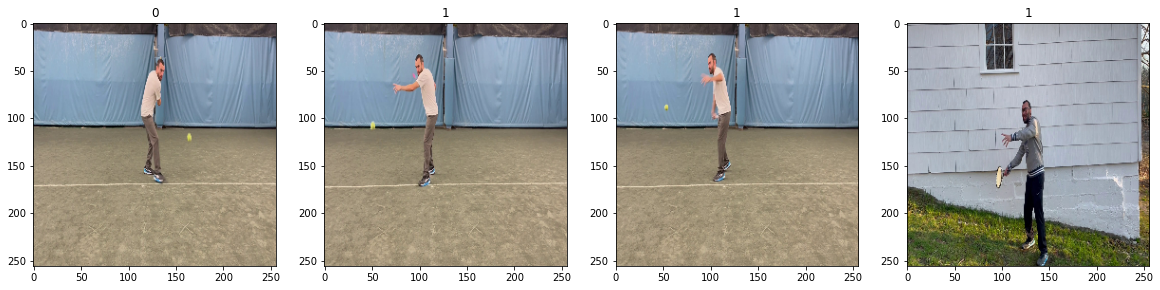

In [12]:
# viewing some  data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

The below cell transforms the images "X" to all be scaled for optimization in the data pipeline.

In [13]:
# scaling data in the pipeline
data = data.map(lambda X,y: (X/255, y))

In [14]:
# The iterator is now scaled from 0 to 1
scaled_iterator = data.as_numpy_iterator()

In [15]:
# renaming the variable batch so that it will always be scaled
batch = scaled_iterator.next()

In [16]:
# confirming the min is 0
batch[0].min()

0.0

In [17]:
# confirming max is 1
batch[0].max()

1.0

Here we are visualizing another batch of data to make sure everything is working on the scaled data.

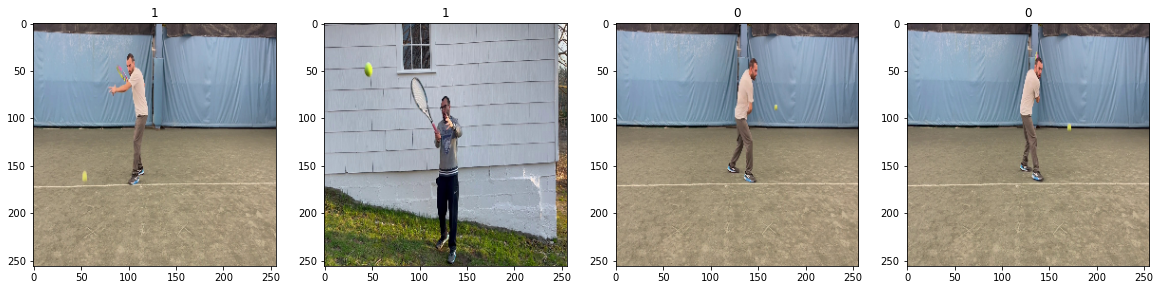

In [18]:
# viewing a batch of data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Here I am ready to start my train, test, split. I check the length of the data (in batches) and we see we have 89 batches

In [19]:
# Checking the length of the data in batches
len(data) 

198

I shuffled the data so that when I eventually use it for modeling it is not biased by learning about the images in any particular order.

In [20]:
# Shuffle the dataset
data_shuffled = data.shuffle(buffer_size=len(data))

This splits that data for training, testing, and validation by the number by batches. I designated 80% to training which is 158 batches, 10% testing which is 15 batches, and 10% for validation which is 15 batches.

In [21]:
# Splitting data into 80% training, 10% testing, 10% validation
train_size = int(len(data_shuffled)*.8)
val_size = int(len(data_shuffled)*.1)+1
test_size = int(len(data_shuffled)*.1)+1

Confirming the splits equal to 198 batches.

In [22]:
# 89 batches
train_size+val_size+test_size

198

The cell below now sets up the variables to either take or skip certain batches.

In [23]:
train = data_shuffled.take(train_size)
val = data_shuffled.skip(train_size).take(val_size)
test = data_shuffled.skip(train_size + val_size).take(test_size)

# Modeling

In [24]:
model = Sequential()

The first layer is a convolutional layer with 16 filters, it is 3 pixels x 3pixels, and a stride of 1 so it goes pixel by pixel. The relu activation function takes into account any non linear patterns. The input shape is the size of our images. The next 2 layers are condensing the rows and width. The last 2 layers are dense fully connected layers and a sigmoid activation function is applied for the output to be between 0 and 1. An output of closer to 1 will be part of the forehand class, and an output of 0 will be closer to the Backhand class.

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [29]:
# Creating a log directory that is my logs folder
logdir = 'logs'

The cell below creates a variable 'tensorboard_callback' which allows you to log the model training while it trains.

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
# This line of code will initiate training, it will take approx 35 minutes
# Model is opened in the cell below as an h5 file
# Uncomment line 4 and 5 to run and save the model
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])
model.save(os.path.join('models', 'forehandbackhandmodel_7.h5'))

Epoch 1/3
  1/158 [..............................] - ETA: 0s - loss: 0.6864 - accuracy: 0.5625WARNING:tensorflow:From /home/adam/anaconda3/envs/learn-env-1/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 172s 1s/step - loss: 0.0975 - accuracy: 0.9572 - val_loss: 2.3050e-04 - val_accuracy: 1.0000
Epoch 2/3
158/158 [==============================] - 182s 1s/step - loss: 1.6350e-04 - accuracy: 1.0000 - val_loss: 7.2041e-05 - val_accuracy: 1.0000
Epoch 3/3
158/158 [==============================] - 178s 1s/step - loss: 3.2029e-05 - accuracy: 1.0000 - val_loss: 2.5789e-05 - val_accuracy: 1.0000


Plotting the performance

In [32]:
#test_loss, test_accuracy = model.evaluate(test)
#print(f"Test Loss: {test_loss}")
#print(f"Test Accuracy: {test_accuracy}")


In [33]:
#val_loss, val_accuracy = model.evaluate(val)
#print(f"Val Loss: {val_loss}")
#print(f"Val Accuracy: {val_accuracy}")

In [34]:
#new_model = load_model(os.path.join('models','forehandbackhandmodel_7.h5'))

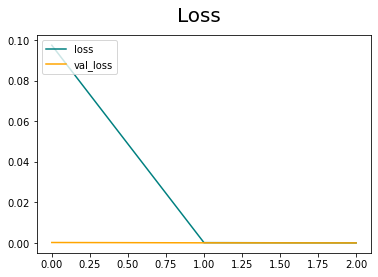

In [35]:
# Visualizing our loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

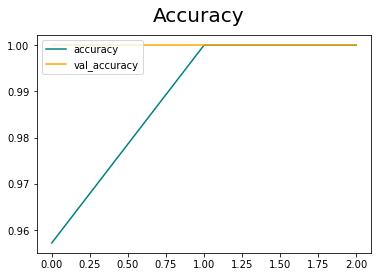

In [36]:
# Visualizing our accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluating performance on our testing data

In [37]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

Our testing data is performing at 100% accuracy.

In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()},  Accuracy:{accuracy.result().numpy()}')

In [ ]:
# Performing a test on an image not in our batch
img = cv2.imread('/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/.git/test_images/monfilsbackhand_193.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

Predicting on a random image the model has never seen before.

In [ ]:
y_hat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# It is predicting what our image is 
y_hat

In [ ]:
if y_hat > 0.5:
    print(f'Predicted class is Forehand')
else:
    print(f'Predicted class is Backhand')

Saving the Model

In [ ]:
model.save(os.path.join('models', 'forehandbackhandmodel.h5'))

In [ ]:
new_model = load_model(os.path.join('models','forehandbackhandmodel_7.h5'))

In [ ]:
y_hat_new = new_model.predict(np.expand_dims(resize/255,0))

In [ ]:
y_hat_new

In [ ]:
if y_hat_new > 0.5:
    print(f'Predicted class is Forehand')
else:
    print(f'Predicted class is Backhand')

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat_new = new_model.predict(X)
    precision.update_state(y, y_hat_new)
    recall.update_state(y, y_hat_new)
    accuracy.update_state(y, y_hat_new)

In [ ]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()},  Accuracy:{accuracy.result().numpy()}')

# Conclusions

The model showed scores of 100% on accuracy, precision, and recall.

## Limitations

Limited amount of data, data consisted only of myself from one camera angle. The model only learned about two-handed backhand shots and not one-handed backhand shots.

## Recommendations

## Next Steps

Obtain more data on all shots (Forehands, Backhands (one-handed backhands), Overheads, Serves, Volleys). Add more variance of different people hitting shots from different camera angles in different backgrounds. 